#### Toward better predictions of militarized inter-state disputes

In [1]:
# reset variables
%reset -f

In [2]:
# all imports necessary for this notebook
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
random.seed(12345)
np.random.seed(12345)

In [4]:
df = pd.read_csv('data/conflicts_dataset.zip')

In [5]:
# check no missing values exist
if df.isnull().values.any():
    print("Warning!! Some missing values were found in the input data")

In [6]:
print("Dataset includes %d rows and %d features"% df.shape)

Dataset includes 641381 rows and 35 features


In [7]:
print("Dataset includes the following features:\n" , df.columns.values, sep='')

Dataset includes the following features:
['year' 'ccode_1' 'ccode_2' 'stateabb_1' 'stateabb_2' 'statenme_1'
 'statenme_2' 'mid_leading' 'disno_leading' 'cinc_1' 'polity2_1'
 'cont_total_1' 'cont_land_1' 'cont_sea_1' 'colcont_total_1'
 'colcont_land_1' 'colcont_sea_1' 'cinc_2' 'polity2_2' 'cont_total_2'
 'cont_land_2' 'cont_sea_2' 'colcont_total_2' 'colcont_land_2'
 'colcont_sea_2' 'contig' 'colcont' 'defense' 'neutrality' 'nonaggression'
 'entente' 'rlregion' 'region1' 'region2' 'distance']


In [8]:
df.head()

,year,ccode_1,ccode_2,stateabb_1,stateabb_2,statenme_1,statenme_2,mid_leading,disno_leading,cinc_1,...,contig,colcont,defense,neutrality,nonaggression,entente,rlregion,region1,region2,distance
0,1920,2,20,USA,CAN,United States of America,Canada,0,-9,0.289566,...,1,1,0,0,0,0,5,5,5,0
1,1921,2,20,USA,CAN,United States of America,Canada,0,-9,0.253229,...,1,1,0,0,0,0,5,5,5,0
2,1922,2,20,USA,CAN,United States of America,Canada,0,-9,0.255595,...,1,1,0,0,0,0,5,5,5,0
3,1923,2,20,USA,CAN,United States of America,Canada,0,-9,0.272078,...,1,1,0,0,0,0,5,5,5,0
4,1924,2,20,USA,CAN,United States of America,Canada,0,-9,0.253591,...,1,1,0,0,0,0,5,5,5,0


In [9]:
print("The dependent variable 'mid_leading' has the following distribution:\n" ,df['mid_leading'].value_counts(), sep='')
peacful_percentage = df['mid_leading'].value_counts(normalize=True)[0] * 100
print("\nWhich means that %.2f%% of the state-pairs in the dataset are (thankfully) not in conflict with one another" %  peacful_percentage)

The dependent variable 'mid_leading' has the following distribution:
0    638912
1      2469
Name: mid_leading, dtype: int64

Which means that 99.62% of the state-pairs in the dataset are (thankfully) not in conflict with one another


In [10]:
# The first seven featues in the dataset (i.e., year, ccode_1, ccode_2, stateabb_1, stateabb_2, statenme_1, statenme_2) are 
# identifications that are unlikely to help in obtaining a general predictor of conflict between states. Accordingly these
# will be excluded from the analysis.

# Take the features from 'cinc_1' to 'distance' in a separate array as the predictors of the output (mid_leading)
x_array = df.loc[:, 'cinc_1':'distance'].values

In [11]:
# Rescale features of x_array to fall between 0-1 because some algorithms (e.g. SVM) yield better performance after rescaling
scaler = MinMaxScaler()
scaler.fit(x_array)
x_array = scaler.transform(x_array)

In [12]:
# Split data into a training and test set, the former will be used for Grid Search with cross-validation
X_train, X_test, y_train, y_test = train_test_split(x_array, df['mid_leading'], stratify=df['mid_leading'], shuffle=True,  test_size=0.25)

In [13]:
# The following defines the search space for each algorithm
# I generally consider more values for faster algorithms (e.g. decision trees) relative to slower ones (e.g. Linear SVC).
# The exception to this is the MLPClassifier, for which I explore a bunch of values despite being relatively slow.

search_space = [['GaussianNB', {}], # GaussianNB has no important parameter to fine-tune (it has a decision threshold which will be considered later). It's included here just for reference.
                ['DecisionTreeClassifier', {'max_depth': [4, 6, 8, 12, 14, 16, 18]}],
                ['RandomForestClassifier', {'max_depth': [4, 6, 8, 12]}],                
                ['LogisticRegression', {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
                ['LinearSVC', {'C': [0.001, 1,  100]}],
                ['GradientBoostingClassifier', {'learning_rate': [0.001, 1,  100]}],
                ['MLPClassifier', {'hidden_layer_sizes': [[100, 100],
                                                          [30, 30, 30, 30],
                                                          [60, 20, 10],
                                                          [10, 10, 10, 10, 10, 10, 10]]}]]


In [14]:
labels = ['classifier', 'parameter_grid']
results = pd.DataFrame.from_records(search_space, columns=labels)
### add columns to hold the results
results['processed'] = False
results['best_parameter'] = None
results['test_score'] = None
results['mean_crossVal_score'] = None
results['mean_crossVal_fit_time'] = None
results['mean_crossVal_score_time'] = None
results['best_estimator_settings_all'] = None
results['evaluation_metric'] = 'roc_auc' # inclded just in case there is a need in the future to optimize on a different metric
results


,classifier,parameter_grid,processed,best_parameter,test_score,mean_crossVal_score,mean_crossVal_fit_time,mean_crossVal_score_time,best_estimator_settings_all,evaluation_metric
0,GaussianNB,{},False,None,None,None,None,None,None,roc_auc
1,DecisionTreeClassifier,"{'max_depth': [4, 6, 8, 12, 14, 16, 18]}",False,None,None,None,None,None,None,roc_auc
2,RandomForestClassifier,"{'max_depth': [4, 6, 8, 12]}",False,None,None,None,None,None,None,roc_auc
3,LogisticRegression,"{'C': [0.001, 0.01, 0.1, 1, 10, 100]}",False,None,None,None,None,None,None,roc_auc
4,LinearSVC,"{'C': [0.001, 1, 100]}",False,None,None,None,None,None,None,roc_auc
5,GradientBoostingClassifier,"{'learning_rate': [0.001, 1, 100]}",False,None,None,None,None,None,None,roc_auc
6,MLPClassifier,"{'hidden_layer_sizes': [[100, 100], [30, 30, 3...",False,None,None,None,None,None,None,roc_auc


# On the coding strategy of Grid Search

Given the time-consuming nature of grid search, and in order to avoid losing the search results that has been already obtained in case of an unexpected error or a computer crash, I coded the Grid search so that it saves the results directly to file and to check that file before it starts optimizing a new classifier. 

In [15]:
# only create a results.csv file if one doesn't already exist
try:
    # start by reading the results.csv file 
    results = pd.read_csv('results.csv')
except:
    results.to_csv('results.csv', index = False)
    

In [16]:
# This method checks the results file to see if a classifier has already been processed.
def classifier_processed(classifier_name, results):
    if (results['processed'][results['classifier'] == classifier_name].iloc[0] == True):  
        return True
    else:
        return False

In [17]:
# This method prints the results of optimization
def print_results(classifier_string, results):
    best_param = results.loc[results['classifier'] == classifier_string, ['best_parameter']].iloc[0].values[0]
    mean_crossVal_score = results.loc[results['classifier'] == classifier_string, ['mean_crossVal_score']].iloc[0].values[0]
    test_score = results.loc[results['classifier'] == classifier_string, ['test_score']].iloc[0].values[0]
    print("Best parameter: " + str(best_param))
    print("Mean cross-validation score of best: %.4f" % mean_crossVal_score)
    print("Test score of best: %.4f" %test_score)

In [18]:
# Given that the output 'mid_leading' is imbalanced, I use stratfied folds with shuffling in the cross-val of the grid search
kfold = StratifiedKFold(n_splits = 4, shuffle = True)

In [19]:
print("\n\n***Start of grid search optimization based on area under ROC curve***\n\n")

for item in search_space:
    classifier_string = item[0]
    parameter_grid = item[1]
    
    # check the results file if this classifier has already been processed
    if classifier_processed(classifier_string, results):
        print(classifier_string + " is already optimized, with the following results \n")
        print_results(classifier_string, results)
        print("\n\n\n")
        continue
        
    print("Working on optimizing: " + classifier_string)
    print("Using the following parameter grid: " + str(parameter_grid) + "\n")
    
    classifier = eval(classifier_string + '''()''')
    
    grid_search = GridSearchCV(classifier, parameter_grid, cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=10)
    grid_search.fit(X_train, y_train)
    
    test_score = None
    predictions_of_best = None
    if hasattr(classifier, 'predict_proba'):
        predictions_of_best = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
        test_score = roc_auc_score(y_test,  predictions_of_best)
    elif hasattr(classifier, 'decision_function'):
        predictions_of_best = grid_search.best_estimator_.decision_function(X_test)
        test_score = roc_auc_score(y_test,  predictions_of_best)
    else: 
        print('Cannot calculate area under ROC curve')
    
        
    # update the results datadrame & file
    results.loc[results['classifier'] == classifier_string, ['processed']] = True
    results.loc[results['classifier'] == classifier_string, ['best_parameter']] = str(grid_search.best_params_)
    results.loc[results['classifier'] == classifier_string, ['test_score']] = test_score
    results.loc[results['classifier'] == classifier_string, ['mean_crossVal_score']] = grid_search.best_score_
    results.loc[results['classifier'] == classifier_string, ['mean_crossVal_fit_time']] = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]
    results.loc[results['classifier'] == classifier_string, ['mean_crossVal_score_time']] = grid_search.cv_results_['mean_score_time'][grid_search.best_index_]
    results.loc[results['classifier'] == classifier_string, ['best_estimator_settings_all']] = str(grid_search.best_estimator_)
    
    # print results of best
    print("\n\nOptimization Results of " + classifier_string + ":")
    print_results(classifier_string, results)
    
    # save results of best to file
    results.to_csv('results.csv', index = False)
    
    # save trained best model to file
    joblib.dump(grid_search.best_estimator_, "trained_models\\" + classifier_string + ".pkl") 
    
    print(80 * "-")
    



***Start of grid search optimization based on area under ROC curve***


Working on optimizing: GaussianNB
Using the following parameter grid: {}

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.6s finished




Optimization Results of GaussianNB:
Best parameter: {}
Mean cross-validation score of best: 0.8920
Test score of best: 0.8852
--------------------------------------------------------------------------------
Working on optimizing: DecisionTreeClassifier
Using the following parameter grid: {'max_depth': [4, 6, 8, 12, 14, 16, 18]}

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  24 out of  28 | elapsed:   49.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  1.0min finished




Optimization Results of DecisionTreeClassifier:
Best parameter: {'max_depth': 8}
Mean cross-validation score of best: 0.9034
Test score of best: 0.8786
--------------------------------------------------------------------------------
Working on optimizing: RandomForestClassifier
Using the following parameter grid: {'max_depth': [4, 6, 8, 12]}

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:   26.0s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   38.7s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   41.5s finished
C:\Users\taor9299\Dropbox\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)




Optimization Results of RandomForestClassifier:
Best parameter: {'max_depth': 12}
Mean cross-validation score of best: 0.9509
Test score of best: 0.9524
--------------------------------------------------------------------------------
Working on optimizing: LogisticRegression
Using the following parameter grid: {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:   20.0s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   25.3s finished
C:\Users\taor9299\Dropbox\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Optimization Results of LogisticRegression:
Best parameter: {'C': 0.1}
Mean cross-validation score of best: 0.9183
Test score of best: 0.9077
--------------------------------------------------------------------------------
Working on optimizing: LinearSVC
Using the following parameter grid: {'C': [0.001, 1, 100]}

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   50.6s remaining:   36.1s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  3.8min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.9min finished




Optimization Results of LinearSVC:
Best parameter: {'C': 1}
Mean cross-validation score of best: 0.9152
Test score of best: 0.9054
--------------------------------------------------------------------------------
Working on optimizing: GradientBoostingClassifier
Using the following parameter grid: {'learning_rate': [0.001, 1, 100]}

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  7.0min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 10.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 10.5min finished




Optimization Results of GradientBoostingClassifier:
Best parameter: {'learning_rate': 0.001}
Mean cross-validation score of best: 0.8828
Test score of best: 0.8701
--------------------------------------------------------------------------------
Working on optimizing: MLPClassifier
Using the following parameter grid: {'hidden_layer_sizes': [[100, 100], [30, 30, 30, 30], [60, 20, 10], [10, 10, 10, 10, 10, 10, 10]]}

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 35.6min remaining: 16.2min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 37.5min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 38.7min finished




Optimization Results of MLPClassifier:
Best parameter: {'hidden_layer_sizes': [30, 30, 30, 30]}
Mean cross-validation score of best: 0.9489
Test score of best: 0.9471
--------------------------------------------------------------------------------


In [20]:
print('\nBased on the area under the ROC curve, the best parameters for the optimized algorithms are as follows\n')
print(results[['classifier', 'best_parameter']])
print(80 * "-")


Based on the area under the ROC curve, the best parameters for the optimized algorithms are as follows

                   classifier                            best_parameter
0                  GaussianNB                                        {}
1      DecisionTreeClassifier                          {'max_depth': 8}
2      RandomForestClassifier                         {'max_depth': 12}
3          LogisticRegression                                {'C': 0.1}
4                   LinearSVC                                  {'C': 1}
5  GradientBoostingClassifier                  {'learning_rate': 0.001}
6               MLPClassifier  {'hidden_layer_sizes': [30, 30, 30, 30]}
--------------------------------------------------------------------------------


In [21]:
print('\nThe mean cross-val and test scores for the optimized algorithms are as follows (sorted by mean_crossVal_score)\n')
print(results[['classifier', 'mean_crossVal_score', 'test_score' ]].sort_values(by = ['mean_crossVal_score'], ascending=False))
print(80 * "-")


The mean cross-val and test scores for the optimized algorithms are as follows (sorted by mean_crossVal_score)

                   classifier mean_crossVal_score test_score
2      RandomForestClassifier            0.950934   0.952418
6               MLPClassifier            0.948861   0.947084
3          LogisticRegression            0.918286   0.907723
4                   LinearSVC            0.915217   0.905424
1      DecisionTreeClassifier            0.903392   0.878606
0                  GaussianNB            0.891952   0.885231
5  GradientBoostingClassifier            0.882821   0.870072
--------------------------------------------------------------------------------


In [22]:
top_ROC_classifier = results[['classifier', 'mean_crossVal_score']].sort_values(by = ['mean_crossVal_score'], ascending=False).iloc[0][0]
top_ROC_parameter = results[['best_parameter', 'mean_crossVal_score']].sort_values(by = ['mean_crossVal_score'], ascending=False).iloc[0][0]
print('Thus, based on the training data, the ' + top_ROC_classifier + ' algorithm with the\nfollowing parameter' + str(top_ROC_parameter) + ' has the highest area under the ROC curve.')
print(80 * "-")

Thus, based on the training data, the RandomForestClassifier algorithm with the
following parameter{'max_depth': 12} has the highest area under the ROC curve.
--------------------------------------------------------------------------------


ROC curves based on training data


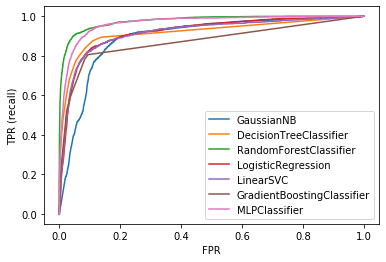

--------------------------------------------------------------------------------


In [24]:
# print ROC curves based on training data
print('ROC curves based on training data')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load("trained_models\\" + classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate area under ROC curve')
        
    plt.plot(fpr, tpr, label=classifier_string)
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.legend(loc= 'lower right')
    
plt.show() 
print(80 * "-")

# Balancing TPR and FPR

Now that we know which classifiers have which ROC curves, let's focus on adjusting the decision thresholds for these classifiers. Based on the ROC curves, I think it'd be desirable to discover the threshold at which we can acheive a high TPR with an accptably low FPR. In other words, I want to find out the point on the ROC curve that would yeild the maximum value for "TPR - FPR". After googling it, the latter fomula turned out to be called __Youden's J statistic__ (https://en.wikipedia.org/wiki/Youden%27s_J_statistic). 

In [25]:
# create three new columns in the results datafame to hold the threshold at which the maximum j-score is obtained in the
# training data, as well as the values of the j-score for the training and test data 
results['j_threshold'] = None
results['j_max_train'] = None
results['j_max_test'] = None

In [26]:
# Optimizing decision thresholds based on Youden's J-statistic
print('\n\nOptimizing decision thresholds based on Youden\'s J-statistic:\n\n')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load("trained_models\\" + classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate area under ROC curve')
    
    # calculate j-scores for all decision thresholds
    j_scores = tpr-fpr
    
    # Find the max j-score and its threshold
    j_ordered = sorted(zip(j_scores,thresholds))
    max_j_train = j_ordered[-1][0]
    threshold_of_max = j_ordered[-1][1]
    
    
    # Now for the test data, calculate Youden's J-Score based on the identified threshold_of_max
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_test)[:, 1]
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_test)

    predictions_of_max_test = []
    for curr_prediction in predictions_of_best:
            if curr_prediction < threshold_of_max:
                predictions_of_max_test.append(0)
            else:
                predictions_of_max_test.append(1)
    
    # Youdin's j-score is also equal to (sensitivity + specificity - 1)
    sensitivity = recall_score(y_test, predictions_of_max_test)
    specificity = recall_score(y_test, predictions_of_max_test, pos_label=0)
    max_j_test = sensitivity + specificity - 1
    
    # save to the results dataframe
    results.loc[results['classifier'] == classifier_string, ['j_max_train']] = max_j_train
    results.loc[results['classifier'] == classifier_string, ['j_max_test']] = max_j_test
    results.loc[results['classifier'] == classifier_string, ['j_threshold']] = threshold_of_max
    
    print('For the classifier ' + classifier_string)
    print('On the training data, the maximum j score is ' + str(max_j_train) + ', which was obtained using the threshold: ' + str(threshold_of_max))
    print('On the test data, and at the same threshold, the j score is ' + str(max_j_test) + ' with the following classification report:\n')
    print(classification_report(y_test,  predictions_of_max_test))
    print('and the following accuracy score ' + str(accuracy_score(y_test,  predictions_of_max_test)))
    print(80 * "-", "\n")



Optimizing decision thresholds based on Youden's J-statistic:


For the classifier GaussianNB
On the training data, the maximum j score is 0.6977952842421056, which was obtained using the threshold: 2.4091629068820417e-08
On the test data, and at the same threshold, the j score is 0.6841039198148349 with the following classification report:

              precision    recall  f1-score   support

           0       1.00      0.81      0.89    159729
           1       0.02      0.88      0.03       617

    accuracy                           0.81    160346
   macro avg       0.51      0.84      0.46    160346
weighted avg       1.00      0.81      0.89    160346

and the following accuracy score 0.8091564491786511
-------------------------------------------------------------------------------- 

For the classifier DecisionTreeClassifier
On the training data, the maximum j score is 0.7653588927453099, which was obtained using the threshold: 0.0043782837127845885
On the test data, and a

In [27]:
top_j_classifier = results[['classifier', 'j_max_train']].sort_values(by = ['j_max_train'], ascending=False).iloc[0][0]
print('Thus, based on the training data, the ' + top_j_classifier + ' algorithm has the highest maximum Youden\'s J-statistic, which means that it has the highest maximum difference betweeb TPR and FPR\n')
print(results[['classifier', 'j_max_train', 'j_max_test', 'j_threshold' ]].sort_values(by = ['j_max_train'], ascending=False))
print(80 * "-")

Thus, based on the training data, the RandomForestClassifier algorithm has the highest maximum Youden's J-statistic, which means that it has the highest maximum difference betweeb TPR and FPR

                   classifier j_max_train j_max_test  j_threshold
2      RandomForestClassifier    0.856377    0.75428    0.0122957
6               MLPClassifier    0.826733   0.775327   0.00317394
1      DecisionTreeClassifier    0.765359   0.710473   0.00437828
3          LogisticRegression    0.732979   0.698904   0.00331871
4                   LinearSVC     0.72474    0.69227    -0.986037
5  GradientBoostingClassifier    0.711389   0.705269   0.00372191
0                  GaussianNB    0.697795   0.684104  2.40916e-08
--------------------------------------------------------------------------------


ROC curves with max. Youden's J-statistic, based on training data


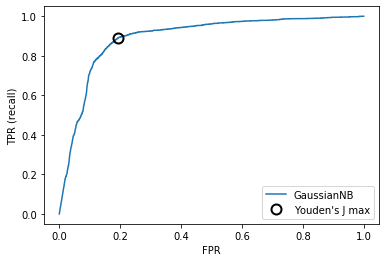

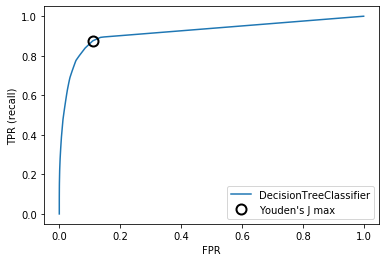

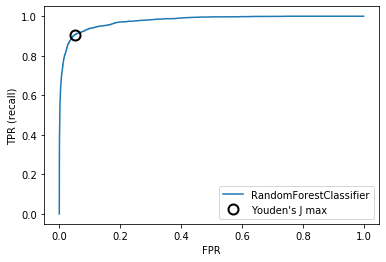

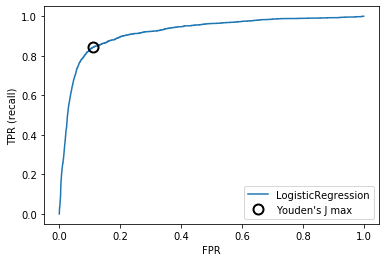

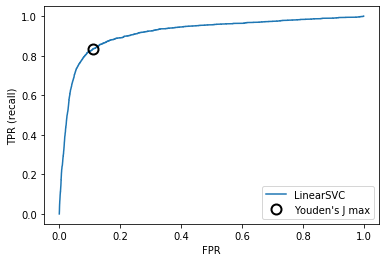

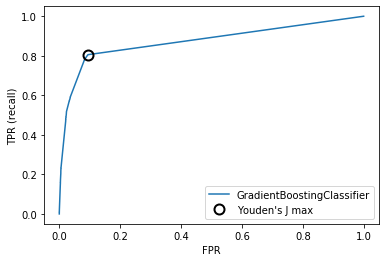

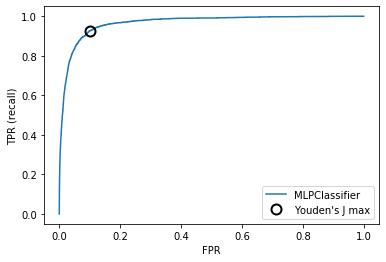

--------------------------------------------------------------------------------


In [28]:
# based on training data, print ROC curves highlighting the thresholds at which the maximum Youden's J-statistic is obtained
print('ROC curves with max. Youden\'s J-statistic, based on training data')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load("trained_models\\" + classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate area under ROC curve')
        
    threshold_of_max = results.loc[results['classifier'] == classifier_string, ['j_threshold']].iloc[0][0]
    close_max_threshold = np.argmin(np.abs(thresholds - threshold_of_max))
    
    plt.plot(fpr, tpr, label=classifier_string)
    plt.plot(fpr[close_max_threshold], tpr[close_max_threshold], 'o', markersize=10,
             label=("Youden's J max"), fillstyle="none", c='k', mew=2)
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.legend(loc= 'lower right')
    plt.show()
    
print(80 * "-")

# Balancing precision and recall

Another desirable property of a classifier is to have a high degree of both precision and recall. In what follows, I seek the decision threshold for each of the identified classsifiers that would yield the maximum f1-score

In [29]:
# create three new columns in the results datafame to hold the threshold at which the maximum f1-score is obtained in the
# training data, as well as the values of the f1-score for the training and test data 
results['f1_threshold'] = None
results['f1_max_train'] = None
results['f1_max_test'] = None


In [30]:
# Optimizing decision thresholds based on the f1-score
print('\n\nOptimizing decision thresholds based on the f1-score\n\n')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load("trained_models\\" + classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        precision, recall, thresholds = precision_recall_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate precision and recall curve')
          
    max_f1_train = 0
    threshold_of_max = None
    for r, p, t in zip(recall, precision, thresholds):
        if p + r == 0: continue
        if (2*p*r)/(p + r) > max_f1_train:
            max_f1_train = (2*p*r)/(p + r) 
            threshold_of_max = t

    
    
    # Now for the test data, calculate the f1-score based on the identified threshold_of_max
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_test)[:, 1]
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_test)

    predictions_of_max_test = []
    for curr_prediction in predictions_of_best:
            if curr_prediction < threshold_of_max:
                predictions_of_max_test.append(0)
            else:
                predictions_of_max_test.append(1)
    
    max_f1_test = f1_score(y_test,  predictions_of_max_test)
    
    # save to the results dataframe
    results.loc[results['classifier'] == classifier_string, ['f1_max_train']] = max_f1_train
    results.loc[results['classifier'] == classifier_string, ['f1_max_test']] = max_f1_test
    results.loc[results['classifier'] == classifier_string, ['f1_threshold']] = threshold_of_max
    
    print('For the classifier ' + classifier_string)
    print('On the training data, the maximum f1 score is ' + str(max_f1_train) + ', which was obtained using the threshold: ' + str(threshold_of_max))
    print('On the test data, and at the same threshold, the f1 score is ' + str(max_f1_test) + ' with the following classification report:\n')
    print(classification_report(y_test,  predictions_of_max_test))
    print('and the following accuracy score ' + str(accuracy_score(y_test,  predictions_of_max_test)))
    print(80 * "-", "\n")



Optimizing decision thresholds based on the f1-score


For the classifier GaussianNB
On the training data, the maximum f1 score is 0.05974293059125964, which was obtained using the threshold: 0.9999972767901013
On the test data, and at the same threshold, the f1 score is 0.057008613938919345 with the following classification report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    159729
           1       0.03      0.29      0.06       617

    accuracy                           0.96    160346
   macro avg       0.51      0.63      0.52    160346
weighted avg       0.99      0.96      0.98    160346

and the following accuracy score 0.9624499519788458
-------------------------------------------------------------------------------- 

For the classifier DecisionTreeClassifier
On the training data, the maximum f1 score is 0.28581173260572984, which was obtained using the threshold: 0.15789473684210525
On the test data, and at the sa

In [31]:
top_f1_classifier = results[['classifier', 'f1_max_train']].sort_values(by = ['f1_max_train'], ascending=False).iloc[0][0]
print('Thus, based on the training data, the ' + top_f1_classifier + ' algorithm has the highest maximum f1-score\n')
print(results[['classifier', 'f1_max_train', 'f1_max_test', 'f1_threshold' ]].sort_values(by = ['f1_max_train'], ascending=False))
print(80 * "-")

Thus, based on the training data, the RandomForestClassifier algorithm has the highest maximum f1-score

                   classifier f1_max_train f1_max_test f1_threshold
2      RandomForestClassifier     0.524093     0.26087     0.150002
6               MLPClassifier     0.302521    0.230514     0.181949
1      DecisionTreeClassifier     0.285812    0.203494     0.157895
5  GradientBoostingClassifier     0.174428    0.152572    0.0095581
4                   LinearSVC     0.137382    0.130456    -0.867474
3          LogisticRegression     0.129893    0.122554    0.0653577
0                  GaussianNB    0.0597429   0.0570086     0.999997
--------------------------------------------------------------------------------


Precision-recall curves with maximum f1-scoares, based on training data


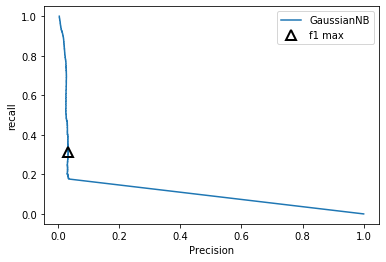

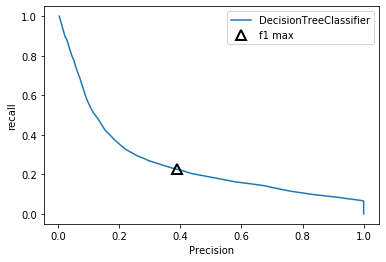

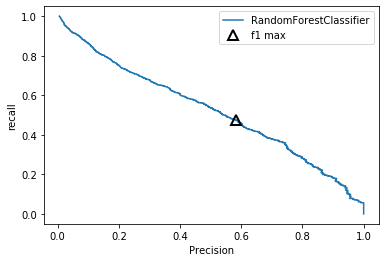

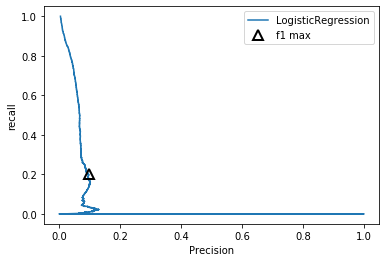

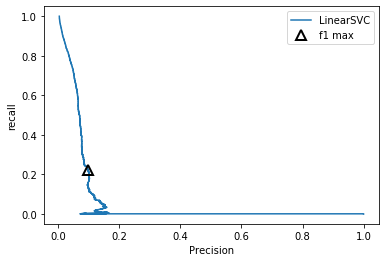

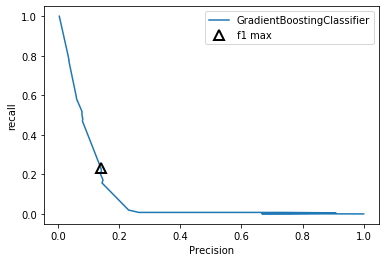

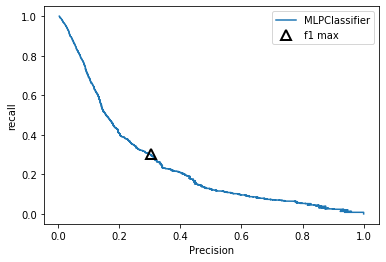

-------------------------------------------------------------------------------- 



In [32]:
print('Precision-recall curves with maximum f1-scoares, based on training data')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load("trained_models\\" + classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        precision, recall, thresholds = precision_recall_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate precision and recall curve')
    
    threshold_of_max = results.loc[results['classifier'] == classifier_string, ['f1_threshold']].iloc[0][0]
    close_max_threshold = np.argmin(np.abs(thresholds - threshold_of_max))
    
    plt.plot(precision, recall, label=classifier_string)
    plt.xlabel("Precision")
    plt.ylabel("recall")
    plt.plot(precision[close_max_threshold], recall[close_max_threshold], '^', markersize=10,
             label=("f1 max"), fillstyle="none", c='k', mew=2)
    plt.legend(loc= 'upper right')
    plt.show()
    
print(80 * "-", "\n")

ROC curves with max. Youden's J-statistic & max. f1-score, based on training data


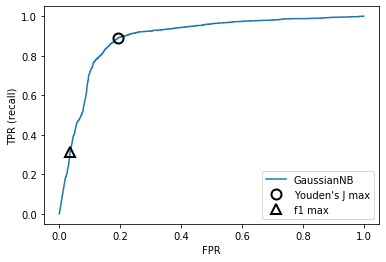

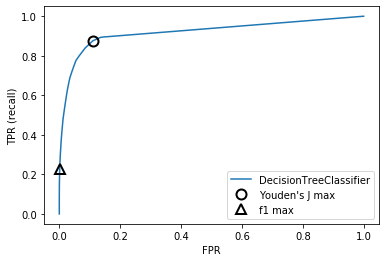

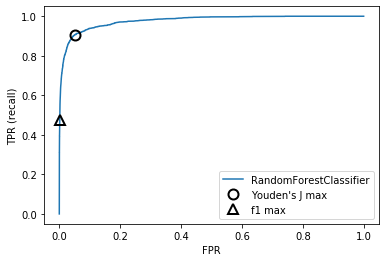

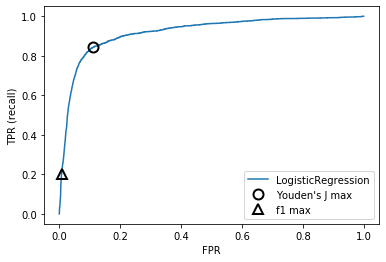

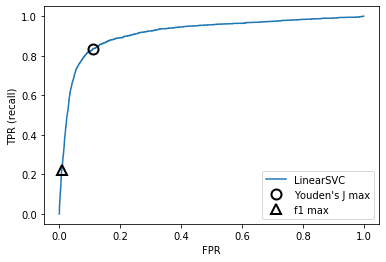

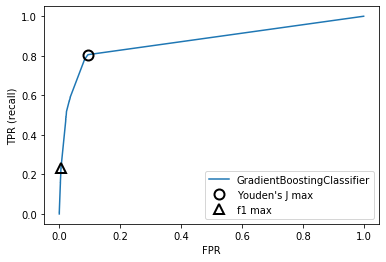

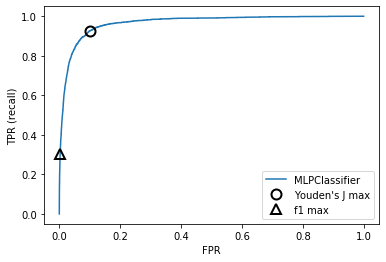

--------------------------------------------------------------------------------


In [33]:
# To highlight the difference between the two evaluation metrics, print ROC curves highlighting both the thresholds at which 
# the maximum Youden's J-statistic is obtained and the threshold at which the maximum f1-score is obtained
print('ROC curves with max. Youden\'s J-statistic & max. f1-score, based on training data')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load("trained_models\\" + classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate area under ROC curve')
        
    j_threshold_of_max = results.loc[results['classifier'] == classifier_string, ['j_threshold']].iloc[0][0]
    j_close_max_threshold = np.argmin(np.abs(thresholds - j_threshold_of_max))
    
    f1_threshold_of_max = results.loc[results['classifier'] == classifier_string, ['f1_threshold']].iloc[0][0]
    f1_close_max_threshold = np.argmin(np.abs(thresholds - f1_threshold_of_max))
    
    plt.plot(fpr, tpr, label=classifier_string)
    plt.plot(fpr[j_close_max_threshold], tpr[j_close_max_threshold], 'o', markersize=10,
             label=("Youden's J max"), fillstyle="none", c='k', mew=2)
    plt.plot(fpr[f1_close_max_threshold], tpr[f1_close_max_threshold], '^', markersize=10,
             label=("f1 max"), fillstyle="none", c='k', mew=2)
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.legend(loc= 'lower right')
    plt.show()
    
print(80 * "-")

# Some substantive predictions

In [34]:
# Examine the predicted probabilities of MIDs based on the classifier with the largest area under the ROC curve

roc_trained_classifier = joblib.load("trained_models\\" + top_ROC_classifier + '.pkl')
if hasattr(trained_classifier, 'predict_proba'):
    df['predictions_ROC_best'] = roc_trained_classifier.predict_proba(x_array)[:, 1]
elif hasattr(trained_classifier, 'decision_function'):
    df['predictions_ROC_best'] = roc_trained_classifier.decision_function(x_array)

In [35]:
# for the last year in the dataset (2009)
print(df[['year', 'stateabb_1', 'stateabb_2', 'predictions_ROC_best' ]].sort_values(by = ['predictions_ROC_best'], ascending=False).query('year==2009'))

print(80 * "-")

        year stateabb_1 stateabb_2  predictions_ROC_best
409804  2009        RUS        JPN              0.716667
134720  2009        COL        VEN              0.597529
386228  2009        TUR        GRC              0.588033
626841  2009        CHN        PHI              0.512074
606307  2009        ISR        LEB              0.472690
...      ...        ...        ...                   ...
238097  2009        URU        EQG              0.000102
108906  2009        URU        NIC              0.000076
99047   2009        URU        SAL              0.000076
53295   2009        URU        JAM              0.000076
476943  2009        BAH        MAA              0.000074

[12555 rows x 4 columns]
--------------------------------------------------------------------------------


Mean predictions of MID by year


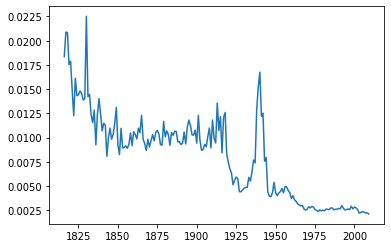

In [36]:
print('Mean predictions of MID by year')
plt.plot(df.groupby(['year'])['predictions_ROC_best'].mean())
plt.show()

Mean predictions of MID by year adjusting for the average capabilities of the two states in the dyad


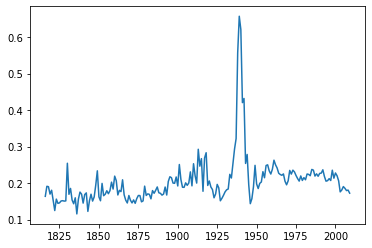

--------------------------------------------------------------------------------


In [37]:
print('Mean predictions of MID by year adjusting for the average capabilities of the two states in the dyad')
plt.plot(df.groupby(['year'])['predictions_ROC_best'].mean() / (df.groupby(['year'])['cinc_1'].mean() + df.groupby(['year'])['cinc_2'].mean()))
plt.show()
print(80 * "-")

In [38]:
# save results of best to file
results.to_csv('results.csv', index = False)

In [39]:
results

,classifier,parameter_grid,processed,best_parameter,test_score,mean_crossVal_score,mean_crossVal_fit_time,mean_crossVal_score_time,best_estimator_settings_all,evaluation_metric,j_threshold,j_max_train,j_max_test,f1_threshold,f1_max_train,f1_max_test
0,GaussianNB,{},True,{},0.885231,0.891952,0.99875,0.238125,"GaussianNB(priors=None, var_smoothing=1e-09)",roc_auc,2.40916e-08,0.697795,0.684104,0.999997,0.0597429,0.0570086
1,DecisionTreeClassifier,"{'max_depth': [4, 6, 8, 12, 14, 16, 18]}",True,{'max_depth': 8},0.878606,0.903392,6.22137,0.08,"DecisionTreeClassifier(class_weight=None, crit...",roc_auc,0.00437828,0.765359,0.710473,0.157895,0.285812,0.203494
2,RandomForestClassifier,"{'max_depth': [4, 6, 8, 12]}",True,{'max_depth': 12},0.952418,0.950934,14.3515,0.2466,"RandomForestClassifier(bootstrap=True, class_w...",roc_auc,0.0122957,0.856377,0.75428,0.150002,0.524093,0.26087
3,LogisticRegression,"{'C': [0.001, 0.01, 0.1, 1, 10, 100]}",True,{'C': 0.1},0.907723,0.918286,3.28865,0.082625,"LogisticRegression(C=0.1, class_weight=None, d...",roc_auc,0.00331871,0.732979,0.698904,0.0653577,0.129893,0.122554
4,LinearSVC,"{'C': [0.001, 1, 100]}",True,{'C': 1},0.905424,0.915217,42.4831,0.074975,"LinearSVC(C=1, class_weight=None, dual=True, f...",roc_auc,-0.986037,0.72474,0.69227,-0.867474,0.137382,0.130456
5,GradientBoostingClassifier,"{'learning_rate': [0.001, 1, 100]}",True,{'learning_rate': 0.001},0.870072,0.882821,210.322,0.364,GradientBoostingClassifier(criterion='friedman...,roc_auc,0.00372191,0.711389,0.705269,0.0095581,0.174428,0.152572
6,MLPClassifier,"{'hidden_layer_sizes': [[100, 100], [30, 30, 3...",True,"{'hidden_layer_sizes': [30, 30, 30, 30]}",0.947084,0.948861,322.499,2.52153,"MLPClassifier(activation='relu', alpha=0.0001,...",roc_auc,0.00317394,0.826733,0.775327,0.181949,0.302521,0.230514
